Fully supervised learning

In [1]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

In [2]:
from camelyon.log_ops import get_child_run_ids
parent_ids = [
    "f08b1ffb953642beac10eed1123fa86e",
    "d53a4bccacef49fba18dbb84c729642e",
    "6af66ffd58974a528b548ae14a1949fa",
    "33d9a428338d439c87ef3d71b56b4bba",
    "a78b200c4852456487610601498c5918",
    "01b9199b25c2458bb75c846c416f6c03",
    "e6abbddc1f7e4e7a96e8fc3db52dff38",
]

rows = list()
for parent_id in parent_ids:
    run_ids = get_child_run_ids(parent_id)

    for run_id in run_ids:
        row = mlflow.get_run(run_id)
        if "test_auroc" not in row.data.metrics:
            continue
        auroc = row.data.metrics["test_auroc"]
        auprc = row.data.metrics["test_prauc"]
        sampling_ratio = row.data.params["sampling_ratio"]
        
        rows.append({"auroc":auroc, "auprc":auprc, "sampling_ratio":sampling_ratio})

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) 데이터 로드 & 필터링
df = pd.read_csv('/vast/AI_team/gshwang/code/250429_attinduc_anno_test/notebooks/JofPATH/250519_experiments.csv')
df = df[
    (df['dataset'] == 'camelyon') &
    (df['sampling_ratio'] == 1) &
    (df['morphology_value'] == 0) &
    (df['model'].isin(['abmil', 'rank'])) &
    (df['random_state'].between(2018, 2027))
]

# 2) 모델 이름 매핑
df['Model'] = df['model'].map({
    'abmil': 'AB-MIL',
    'rank':  'Rank Induction'
})

# 3) AB-MIL 은 anno_ratio=0 으로 처리
df.loc[df['Model']=='AB-MIL', 'anno_ratio'] = 0.0

# 4) melt: AUROC/AUPRC long 포맷
df_long = df.melt(
    id_vars=['Model','anno_ratio'], 
    value_vars=['auroc','auprc'], 
    var_name='Metric', 
    value_name='Metric Value'
)
df_long['Metric'] = df_long['Metric'].map({'auroc':'AUROC','auprc':'AUPRC'})

# 5) x축 순서 (0부터 시작)
anno_order = sorted(df_long['anno_ratio'].unique())


/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/seaborn/cm.py:1582: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/seaborn/cm.py:1583: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps

In [24]:
rank_induction_df = df_long.loc[
    (df_long["Model"] == "Rank Induction") & 
    (df_long["Metric"] == "AUROC")
].copy()
rank_induction_df.rename(
    columns={
        "anno_ratio": "Fraction of Annotated WSIs",
        "Metric Value": "AUROC",
        }, inplace=True
)
rank_induction_df.head(2)

,Model,Fraction of Annotated WSIs,Metric,AUROC
0,Rank Induction,1.00,AUROC,0.863520
1,Rank Induction,0.05,AUROC,0.795153


<Axes: xlabel='Fraction of Annotated WSIs', ylabel='AUROC'>

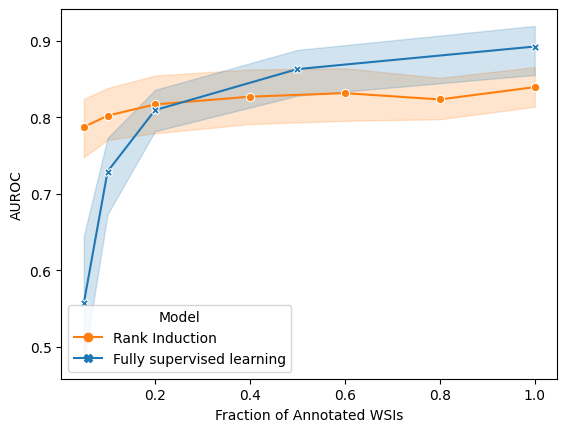

In [27]:
from tableone import TableOne
import pandas as pd
data = pd.DataFrame(rows)
data["Model"] = "Fully supervised learning"
data.rename(columns={"auroc": "AUROC", "sampling_ratio":"Fraction of Annotated WSIs"}, inplace=True)

plot_df = pd.concat([rank_induction_df, data], ignore_index=True)

sns.lineplot(
    data=plot_df,
    x="Fraction of Annotated WSIs",
    y="AUROC",
    hue="Model",
    style="Model",
    markers=True,
    dashes=False,
    palette=["#ff7f0e", "#1f77b4"],
)

# TableOne(data, groupby="sampling_ratio", missing=False, overall=False, decimals=4)

In [30]:
plot_df.groupby(["Model", "Fraction of Annotated WSIs"]).mean()

/tmp/ipykernel_2399105/2891364072.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plot_df.groupby(["Model", "Fraction of Annotated WSIs"]).mean()


AUROC     auprc
Model                     Fraction of Annotated WSIs                    
Fully supervised learning 0.05                        0.557292  0.530020
                          0.1                         0.729257  0.690326
                          0.2                         0.809503  0.779065
                          0.5                         0.863122  0.846082
                          1.0                         0.892620  0.882746
Rank Induction            0.05                        0.787372       NaN
                          0.1                         0.802270       NaN
                          0.2                         0.816964       NaN
                          0.4                         0.827066       NaN
                          0.6                         0.831709       NaN
                          0.8                         0.823469       NaN
                          1.0                         0.839541       NaN